### Imports + load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize

per = pd.read_csv("Data/PerceptualTaskData.csv")      
sym = pd.read_csv("Data/SymptomData.csv")          

per.head(), sym.head()

(    IDcode  Age  Sex  Trial  Response  Stimulus  Confidence
 0  4676165   67    1      1         0        16           1
 1  4676165   67    1      2         0         8           2
 2  4676165   67    1      3         1        56           3
 3  4676165   67    1      4         1        32           3
 4  4676165   67    1      5         0        48           3,
     IDcode  Age  Sex  AnxiousDepression  Compulsivity  SocialWithdrawal
 0  4676165   67    1           0.997218     -1.174643          0.503585
 1  4676332   28    1          -0.488935     -1.178822          0.197481
 2  4676373   19    1          -1.180051     -1.219396         -1.101509
 3  4676552   24    1          -0.280664     -0.475714         -0.558212
 4  4676560   34    1           2.167959      1.647215          0.403726)

## D' and criterion c

In [6]:
def loglinear_rate(k,n):
    # Hit and false-alarm rates were corrected using the log-linear rule (Hautus, 1995) to avoid infinite z-scores when proportions equalled 0 or 1.
    return (k + 0.5)/(n + 1)

def compute_dprime_c (stim, resp):
    # stim: signed stimulus, resp: 0/1. We take right as the hit
    sig = stim > 0
    noise = stim < 0

    # Stimulus == 0 can be ignored for SDT rates
    H = resp[sig].sum()
    FA = resp[noise].sum()

    hr  = loglinear_rate(H, sig.sum())
    far = loglinear_rate(FA, noise.sum())

    zH = norm.ppf(hr)
    zF = norm.ppf(far)

    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return dprime, c


## Meta-d' helper function

In [7]:
def counts_for_subject(df, K=6):
    df = df[df["Stimulus"] != 0].copy()
    stim = df["Stimulus"].values
    resp = df["Response"].values
    conf = df["Confidence"].values

    cat = np.empty(len(df), dtype=int)

    # resp=0 => S1 (lef) response: map conf=6 to cat=1 (high), conf=1 naar cat=K (low)
    m0 = resp == 0
    cat[m0] = K - conf[m0] + 1

    # resp=1 => S2 (right) response: map conf=1 to cat=K+1 (low), conf=6 to cat=2K (low)
    m1 = ~m0
    cat[m1] = K + conf[m1]

    S1 = stim < 0
    S2 = stim > 0

    nR_S1 = np.array([(cat[S1] == i).sum() for i in range(1, 2*K + 1)])
    nR_S2 = np.array([(cat[S2] == i).sum() for i in range(1, 2*K + 1)])
    return nR_S1, nR_S2

## Likelihood + optimizer

In [8]:
def metad_negloglik(params, nR_S1, nR_S2, c, K): #Had some help of AI
    meta_d = params[0]

    # enforce monotonically ordered criteria via cumulative positive steps
    s1_steps = np.exp(params[1:K])         # K-1
    s2_steps = np.exp(params[K:2*K-1])     # K-1

    s1_crit = np.sort(c - np.cumsum(s1_steps))  # below c
    s2_crit = np.sort(c + np.cumsum(s2_steps))  # above c

    muS1 = -meta_d / 2
    muS2 =  meta_d / 2

    # Edges for S1 response bins: (-inf ... s1_crit ... c)
    s1_edges = np.concatenate(([-np.inf], s1_crit, [c]))
    # S1-response category probs for a given mu:
    def p_respS1(mu):
        p = norm.cdf(s1_edges[1:], loc=mu) - norm.cdf(s1_edges[:-1], loc=mu)
        return p[::-1]  # high->low confidence

    # Edges for S2 response bins: (c ... s2_crit ... inf)
    s2_edges = np.concatenate(([c], s2_crit, [np.inf]))
    def p_respS2(mu):
        return norm.cdf(s2_edges[1:], loc=mu) - norm.cdf(s2_edges[:-1], loc=mu)  # low->high

    pS1 = np.concatenate((p_respS1(muS1), p_respS2(muS1)))
    pS2 = np.concatenate((p_respS1(muS2), p_respS2(muS2)))

    eps = 1e-12
    ll = (nR_S1 * np.log(pS1 + eps)).sum() + (nR_S2 * np.log(pS2 + eps)).sum()
    return -ll

def fit_metad(nR_S1, nR_S2, c, K=6): #Had some helf of AI
    init = np.zeros(1 + 2*(K-1))
    init[0] = 1.0
    init[1:] = np.log(0.5)

    bounds = [(1e-3, 6.0)] + [(-5, 5)]*(2*(K-1))

    res = minimize(
        metad_negloglik,
        init,
        args=(nR_S1, nR_S2, c, K),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 80}  
    )
    return res.x[0], res.success

## D', meta-d', mean confidence merging with symptom dimension

In [9]:
K = 6
rows = []

for pid, dfsub in per.groupby("IDcode"):
    stim = dfsub["Stimulus"].values
    resp = dfsub["Response"].values

    dprime, c = compute_dprime_c(stim, resp)

    nR_S1, nR_S2 = counts_for_subject(dfsub, K = K)
    metad, ok = fit_metad(nR_S1, nR_S2, c, K=K)

    mean_conf = dfsub["Confidence"].mean()

    rows.append({
        "IDcode": pid,
        "dprime": dprime,
        "metad" : metad if ok else np.nan,
        "mean_conf": mean_conf
    })

metrics = pd.DataFrame(rows)

#merge with symptom dimensions (had some help of AI)
df = metrics.merge(sym[["IDcode", "Compulsivity"]], on = "IDcode", how = "inner")

#tertiles
df["group"] = pd.qcut(df["Compulsivity"], 3, labels = ["low", "mid", "high"])

df.head()

,IDcode,dprime,metad,mean_conf,Compulsivity,group
0,944548,1.915309,1.332667,3.779412,-0.621615,low
1,953958,1.580684,1.163596,4.080882,-0.123265,mid
2,954010,1.802609,1.205050,5.036765,1.126410,high
3,954564,1.049829,1.034292,5.301471,0.330763,high
4,954995,1.560552,0.735497,4.625000,-0.504122,mid


## Make the barplot

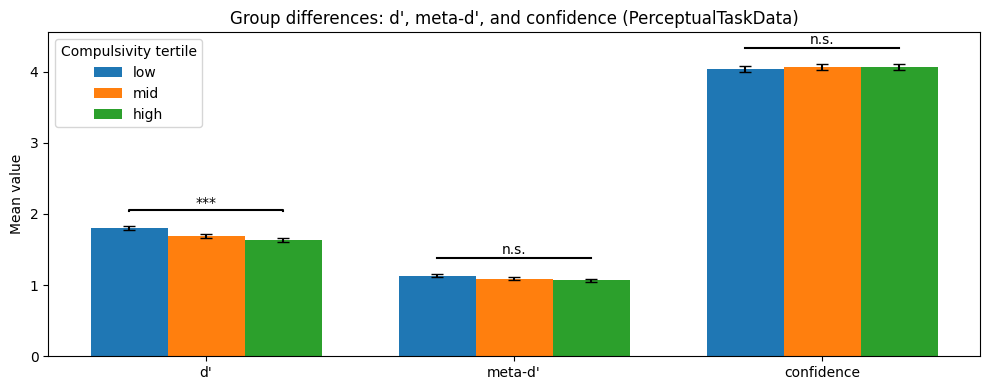

{"d'": (0.0001462220894119103, '***'), "meta-d'": (0.05425179421388288, 'n.s.'), 'confidence': (0.6088944556966358, 'n.s.')}


In [10]:
def mean_sem(x):
    x = x.dropna()
    return x.mean(), x.std(ddof=1) / np.sqrt(len(x))

order = ["low", "mid", "high"]
metrics_to_plot = [("dprime", "d'"), ("metad", "meta-d'"), ("mean_conf", "confidence")]

means = {m: [] for m, _ in metrics_to_plot}
sems  = {m: [] for m, _ in metrics_to_plot}

for g in order:
    sub = df[df["group"] == g]
    for m, _ in metrics_to_plot:
        mu, se = mean_sem(sub[m])
        means[m].append(mu)
        sems[m].append(se)

# significance (high vs low)
pvals = {}
for m, _ in metrics_to_plot:
    low_vals  = df[df["group"] == "low"][m].dropna()
    high_vals = df[df["group"] == "high"][m].dropna()
    pvals[m] = ttest_ind(low_vals, high_vals, equal_var=False).pvalue

def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "n.s."

# plot
fig, ax = plt.subplots(figsize=(10, 4))

x = np.arange(len(metrics_to_plot))
w = 0.25

colors = ["tab:blue", "tab:orange", "tab:green"]
for i, g in enumerate(order):
    vals = [means[m][i] for m, _ in metrics_to_plot]
    err  = [sems[m][i]  for m, _ in metrics_to_plot]
    ax.bar(x + (i-1)*w, vals, width=w, yerr=err, capsize=4, color=colors[i], label=g)

ax.set_xticks(x)
ax.set_xticklabels([lab for _, lab in metrics_to_plot])
ax.set_ylabel("Mean value")
ax.set_title("Group differences: d', meta-d', and confidence (PerceptualTaskData)")

# add stars above low vs high (span from first bar to third bar within each metric cluster)
for j, (m, lab) in enumerate(metrics_to_plot):
    y_max = max(means[m][0] + sems[m][0], means[m][2] + sems[m][2])
    y = y_max + 0.05*(ax.get_ylim()[1] - ax.get_ylim()[0])
    x1 = j + (-1)*w
    x2 = j + ( 1)*w
    ax.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], lw=1.5, c="black")
    ax.text((x1+x2)/2, y+0.015, stars(pvals[m]), ha="center", va="bottom")

ax.legend(title="Compulsivity tertile")
plt.tight_layout()
plt.show()

print({lab: (pvals[m], stars(pvals[m])) for m, lab in metrics_to_plot})